# TP3 : Inférence variationnelle dans le modèle *Latent Dirichlet Allocation*

## G3 SDI - Estimation Avancée

Dans ce dernier TP, on s'intéresse au modèle *Latent Dirichlet Allocation* ([Blei et al. (2003)](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)), un célèbre modèle probabiliste pour données textuelles. Voir le .pdf joint à l'archive pour la description complète du modèle. Dans ce modèle, la loi a posteriori est intractable, et nous utiliserons l'approche variationnelle pour en trouver une approximation.

Using the notations from the .pdf file describing the model, the intractable posterior is :
$$p(\boldsymbol{\beta}, \boldsymbol{\theta} | \mathcal{D}),$$
which we are going to approximate in the following way :
$$\simeq \left[ \prod_{k=1}^K q(\boldsymbol{\beta_k}) \right] \left[ \prod_{d=1}^D q(\boldsymbol{\theta_d}) \right] , $$
with :
* $q(\boldsymbol{\beta_k})$ a Dirichlet distribution (of size V) with variational parameters $[\lambda_{k1}, ...,\lambda_{kV}]$ ;
* $q(\boldsymbol{\theta_d})$ a Dirichlet distribution (of size K) with variational parameters $[\gamma_{d1}, ...,\gamma_{dK}]$.

### Instructions

1. Renommez votre notebook sous la forme `tp3_Nom1_Nom2.ipynb`. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposez votre notebook sur Moodle dans la section prévue à cet effet avant la date limite.

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Compte-rendu écrit par AMORRI, MILANO, 18/12/2025.
</div>

In [1]:
# Import usual libraries
import numpy as np
from matplotlib import pyplot as plt

# Specific for this lab
from sklearn.decomposition import LatentDirichletAllocation

**Q0.** À quelle difficulté principale se heurterait un algorithme MCMC dans ce contexte ?

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

La principale difficulté est **le coût de calcul** et la convergence lente. Pour de grands jeux de données (grand nombre de documents $D$ et grand vocabulaire $V$), échantillonner les variables latentes pour chaque mot de chaque document à chaque itération est très coûteux. 

De plus, il est difficile de diagnostiquer quand la chaîne a convergé vers la distribution cible. L'inférence variationnelle ($VI$) transforme ce problème d'échantillonnage en un problème d'optimisation, souvent plus rapide.

</div>

### Partie 1 - Préparation des données

On utilise le dataset `20newsgroups` (voir par exemple [ici](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset)), qui contient des messages postés dans différentes catégories sur un forum dans les années 90.

In [3]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

# Load data
newsgroups = fetch_20newsgroups().data

**Q1.** En LDA, sous quelle forme est représentée un document ?

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

En LDA, un document est représenté comme un **"Sac de mots" (Bag-of-Words)**. L'ordre des mots n'a aucune importance, seule leur fréquence (le nombre d'occurrences de chaque mot du vocabulaire dans le document) compte. C'est un vecteur de taille $V$.

</div>

**Q2.** Créer la matrice des données en utilisant la fonction `CountVectorizer` en utilisant les arguments :
* `max_df` = 0.95 ;
* `max_features` = 1000 ;
* `stop_words` = "english".

Expliquer à quoi correspondent ces 3 arguments.

In [4]:
tf_vectorizer = CountVectorizer(max_df=0.95, max_features=1000, stop_words='english')
X = tf_vectorizer.fit_transform(newsgroups)

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

**max_df=0.95** : On ignore les mots qui apparaissent dans plus de 95% des documents (ce sont des "stop words" contextuels, trop fréquents pour être informatifs).

**max_features=1000** : On ne garde que les 1000 mots les plus fréquents du corpus (réduit la dimension $V$).

**stop_words="english"** : Supprime les mots de liaison anglais courants (the, is, at, which...).

</div>

**Q3.** Rappeler à quoi correspondent les dimensions de la matrice des données obtenues.

Calculer son pourcentage d'éléments non-nuls. Est-ce surprenant ?

In [5]:
n_docs, n_vocab = X.shape
print(f"Dimensions : {X.shape}")

# Calcul du pourcentage non-nul
sparsity = X.nnz / (n_docs * n_vocab) * 100
print(f"Pourcentage d'éléments non-nuls : {sparsity:.2f}%")

Dimensions : (11314, 1000)
Pourcentage d'éléments non-nuls : 4.42%


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

**Dimensions et Sparsité:**

La matrice obtenue est de taille $(D \times V)$ où $D$ est le nombre de documents et $V=1000$.

**Pourcentage d'éléments non-nuls : $4.42$%**

Ce n'est pas surprenant que ce pourcentage soit très faible (matrice creuse ou sparse). Chaque document n'utilise qu'une toute petite fraction des 1000 mots disponibles dans le dictionnaire entier.

</div>

### Partie 2 - Latent Dirichlet Allocation (LDA)

**Q4.** Entraîner le modèle LDA avec les arguments suivants :
* `n_components` = 8 ;
* `learning_method` = "online" ;
* `max_iter` = 50 ;
* `doc_topic_prior` = 0.1 ;
* `topic_word_prior` = 0.1 ;
* `learning_offset` = 100.

Idem, expliquer à quoi correspondent chacun de ces arguments.

In [6]:
lda = LatentDirichletAllocation(
    n_components=8,
    learning_method="online",
    max_iter=50,
    doc_topic_prior=0.1,
    topic_word_prior=0.1,
    learning_offset=100.,
    random_state=0
)
lda.fit(X)

,n_components,8
,doc_topic_prior,0.1
,topic_word_prior,0.1
,learning_method,'online'
,learning_decay,0.7
,learning_offset,100.0
,max_iter,50
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

**n_components=8 :** Le nombre de topics (sujets) $K$ que l'on cherche.

**learning_method="online" :** Utilise l'inférence variationnelle stochastique (minibatchs). C'est plus rapide que "batch" sur de grandes données.

**max_iter=50 :** Nombre d'itérations sur le dataset.

**doc_topic_prior ($\alpha$) :** Paramètre de la loi a priori (Dirichlet) sur la distribution des topics dans les documents.

**topic_word_prior ($\eta$ ou $\beta$) :** Paramètre de la loi a priori (Dirichlet) sur la distribution des mots dans les topics.

**learning_offset :** Paramètre technique pour le learning rate dans la méthode "online" (évite des pas trop grands au début).

</div>

**Q5.** Que contient l'attribut `.components` ?

Comment obtenir le MMSE de $\boldsymbol{\beta}$ à partir de cet attribut ? L'implémenter.

In [9]:
print("Taille de components :", lda.components_.shape)

# MMSE de Beta : Normalisation des lignes pour que la somme fasse 1
beta_mmse = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

Taille de components : (8, 1000)


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

**Contenu :** `.components` contient les paramètres variationnels de la loi de Dirichlet pour chaque topic (souvent notés $\lambda_{k,v}$). Ce sont des *"pseudo-comptes"* de mots par topic.

**MMSE (Minimum Mean Square Error) :** L'estimateur MMSE pour une loi de Dirichlet est son espérance. Pour obtenir la probabilité d'un mot sachant le topic ($\beta_{k,v}$), il faut normaliser ces comptes pour qu'ils somment à 1 par topic.
</div>

**Q6.** À partir de $\hat{\boldsymbol{\beta}}_{MMSE}$, afficher les 10 mots les plus courants par topic. Pouvez-vous interpréter les topics obtenus ?

Si vous souhaitez rajouter certains mots à la liste des stop words pour améliorer l'interprétabilité, utilisez le bloc de code ci-dessous.

In [10]:
feature_names = tf_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(beta_mmse):
    # On prend les indices des 10 plus grandes valeurs
    top_features_ind = topic.argsort()[:-11:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    print(f"Topic {topic_idx}: {', '.join(top_features)}")

Topic 0: space, key, gov, nasa, use, access, chip, netcom, encryption, data
Topic 1: drive, card, edu, use, scsi, ibm, problem, mac, apple, bit
Topic 2: windows, file, edu, 10, 00, program, mail, use, available, 15
Topic 3: edu, university, writes, article, posting, nntp, host, cs, ca, like
Topic 4: god, people, edu, don, think, does, say, just, know, believe
Topic 5: com, writes, article, posting, host, nntp, distribution, hp, ca, reply
Topic 6: ax, max, g9v, b8f, a86, 145, pl, 0d, 1d9, 34u
Topic 7: people, don, said, just, car, like, think, time, know, government


In [12]:
# To add additional stop words

from sklearn.feature_extraction import text 

my_additional_stop_words = ### YOUR LIST HERE ### #list of strings
my_stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Votre réponse ici
</div>

**Q7.** Que contient `lda.transform(X)` ?

Regarder si les documents sont en général plutôt associés à un ou plusieurs topics.

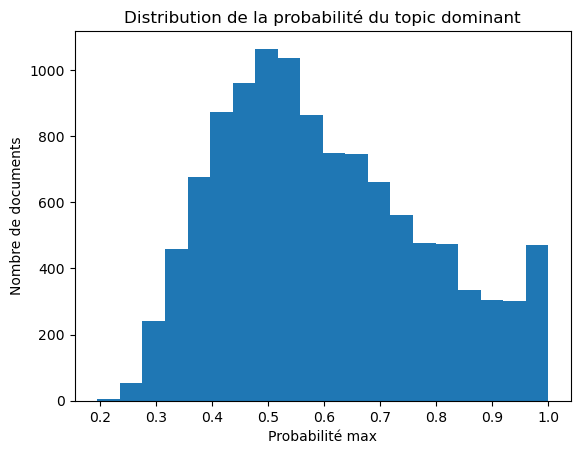

In [13]:
doc_topic_dist = lda.transform(X)

# Vérification si les docs sont mélange ou pur
# On regarde la distribution du max de chaque ligne
max_probs = np.max(doc_topic_dist, axis=1)
plt.hist(max_probs, bins=20)
plt.title("Distribution de la probabilité du topic dominant")
plt.xlabel("Probabilité max")
plt.ylabel("Nombre de documents")
plt.show()

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

La méthode `lda.transform(X)` retourne la distribution a posteriori des topics pour chaque document ($\theta_d$). C'est une matrice $(D \times K)$. La ligne $d$ donne la proportion de chaque sujet dans le document $d$.

L'histogramme des probabilités maximales montre une structure complexe et multimodale :
- **Un pic à 1.0 :** Une partie des documents est parfaitement classée dans un seul topic ("documents purs"), conformément à la contrainte de sparsité imposée par $\alpha=0.1$.
- **Un pic majeur vers 0.5 :** Beaucoup de documents sont ambigus et partagés entre deux topics principaux (mélanges binaires).
- **Une distribution étalée :** : La présence de pics intermédiaires indique que de nombreux documents restent des mélanges flous de plusieurs thématiques.
  
- ***Conclusion :*** Les documents ne sont pas uniformément associés à un seul topic. Bien que le prior $\alpha$ force la spécialisation, la nature des données (catégories sémantiquement proches) entraîne de nombreux chevauchements thématiques.

</div>

### Partie 3 - Pour aller plus loin...

Répondre aux questions sans implémenter les solutions discutées.

**Q8.** Quelle est l'influence des paramètres $\alpha$ et $\eta$ ?

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

Influence de $\alpha$ et $\eta$:
 
Ces hyperparamètres contrôlent la concentration (sparsité) des lois de Dirichlet.
- $\alpha$ faible (< 1) : Les documents sont des mélanges de peu de topics.
- $\eta$ faible (< 1) : Les topics sont constitués de peu de mots prédominants.
</div>

**Q9.** Pour aujourd'hui, le nombre de topics $K$ était fixé à l'avance. Comment pourrait-on apprendre ou choisir la valeur de $K$ ?

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

**Choix de K** : On ne peut pas "apprendre" $K$ avec un LDA standard. On le choisit généralement en :

- Comparant la **perplexité** sur un jeu de test (plus elle est basse, mieux c'est).
- Utilisant une mesure de **Cohérence des topics** (souvent préférée car plus proche de l'interprétation humaine).
- Utilisant des modèles non-paramétriques comme le HDP (Hierarchical Dirichlet Process) qui infère $K$.
  
</div>

**Q10.** Quelles sont les principales limites du modèle LDA et quelles potentielles améliorations proposez-vous ?

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

- **Limites :** Le modèle *"Sac de mots"* perd la sémantique et l'ordre ("Man bites dog" = "Dog bites man"). L'hypothèse d'indépendance des topics est souvent fausse (Politique et Économie sont liés).

- **Améliorations :** Utiliser des modèles neuronaux modernes (BERTopic) qui exploitent les embeddings de mots pour capturer le contexte sémantique, ou le Correlated Topic Model (CTM).
</div>